Import all the required libraries

In [22]:
import pandas as pd
import re

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import re
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Read the csv file

In [23]:
#ds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dice_com-job_us_sample.csv')
# The csv file is stored on a public github repository so that the data file doesn't need to be downloaded into google drive
csv_source = "https://raw.github.com/ZGrootegoed/Capstone/main/dice_com-job_us_sample.csv"
ds = pd.read_csv(csv_source)

Taking care of any missing data

In [24]:
# Replace missing data with more info on where a user could find it
ds['shift'] = ds['shift'].fillna('Please see job description')

# Change the empty spaces to dice.com for completeness
ds['site_name'] = ds['site_name'].fillna('www.dice.com')

# Drop any rows with null or no values written in them
ds.dropna(subset=['company', 'employmenttype_jobstatus', 'jobdescription', 'jobid',
                  'joblocation_address', 'jobtitle', 'skills'], inplace=True)

Cleaning the data

In [25]:
# A function that can be used multiple times for cleaning rows
#which then only keeps the rows that are lowercased and then also rows with # or +
#because some skills or job titles include those values
def clean(text):
  text = text.lower()
  text = re.sub(r'[^a-z+#\s]', ' ', text)
  return text

# Apply the function to the necessary data sets
ds['skills'] = ds['skills'].apply(clean)
ds['jobtitle'] = ds['jobtitle'].apply(clean)

top_titles = ds['jobtitle'].value_counts()
# Used for only keeping the titles where there is at least 20 of them
keep_titles = top_titles[top_titles >= 20].index
ds = ds[ds['jobtitle'].isin(keep_titles)]

Lemmatizer and stemmer

In [26]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# A function for stemming to be applied
def lem_text(words):
  return ' '.join([stemmer.stem(word) for word in words.split()])

# Another function for lemmantizer to be applied
def stem_text(words):
  return ' '.join([lemmatizer.lemmatize(word) for word in words.split()])

ds['skills'] = ds['skills'].apply(lambda x: stem_text(x))
ds['skills'] = ds['skills'].apply(lambda x: lem_text(x))

/tmp/ipython-input-26-1911645162.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['skills'] = ds['skills'].apply(lambda x: stem_text(x))


Encode the job titles

In [27]:
encode_label = LabelEncoder()
ds['labeled_jobtitle'] = encode_label.fit_transform(ds['jobtitle'])

Splitting the dataset into the Training and Test set. Then training the actual model

In [28]:
x = ds['skills']
y = ds['labeled_jobtitle']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Model is trained via a pipeline where common english stop words are removed and to ignore terms mentioned less than two times
# For the Logistic Regression training a max iterations is set as well as an automatic weight adjustment in balance
model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=2)),
                  ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])

model.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Evaluation of the model used

In [29]:
# Evaluating the model using a classification report
y_prediction = model.predict(x_test)
c_report = classification_report(y_test, y_prediction)
print(c_report)

              precision    recall  f1-score   support

           0       0.72      0.64      0.68        36
           1       0.86      0.86      0.86         7
           2       0.40      0.57      0.47         7
           3       0.62      0.38      0.48        39
           4       0.00      0.00      0.00        12
           5       0.20      0.20      0.20         5
           6       0.21      0.75      0.33         4
           7       0.44      0.78      0.56         9
           8       0.50      0.75      0.60         4
           9       0.25      0.17      0.20         6
          10       0.58      0.85      0.69        13
          11       0.38      0.36      0.37        14
          12       0.29      0.33      0.31         6
          13       1.00      1.00      1.00         7
          14       0.17      0.40      0.24         5
          15       0.71      0.25      0.37        48
          16       0.33      0.67      0.44         6
          17       0.09    

Evaluating the model being used with a Confusion matrix

In [30]:
# Confusion matrix for accuracy reporting
cm = confusion_matrix(y_test, y_prediction)
print('Confusion Matrix accuracy score:')
print(cm)
print("The Accuracy of the model:", accuracy_score(y_test, y_prediction))

Confusion Matrix accuracy score:
[[23  0  1 ...  0  0  0]
 [ 0  6  0 ...  0  1  0]
 [ 0  0  4 ...  0  0  1]
 ...
 [ 0  0  0 ...  6  0  2]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  1  4]]
The Accuracy of the model: 0.4625199362041467


Graph 1: Count jobs per state and onle retreive top 20

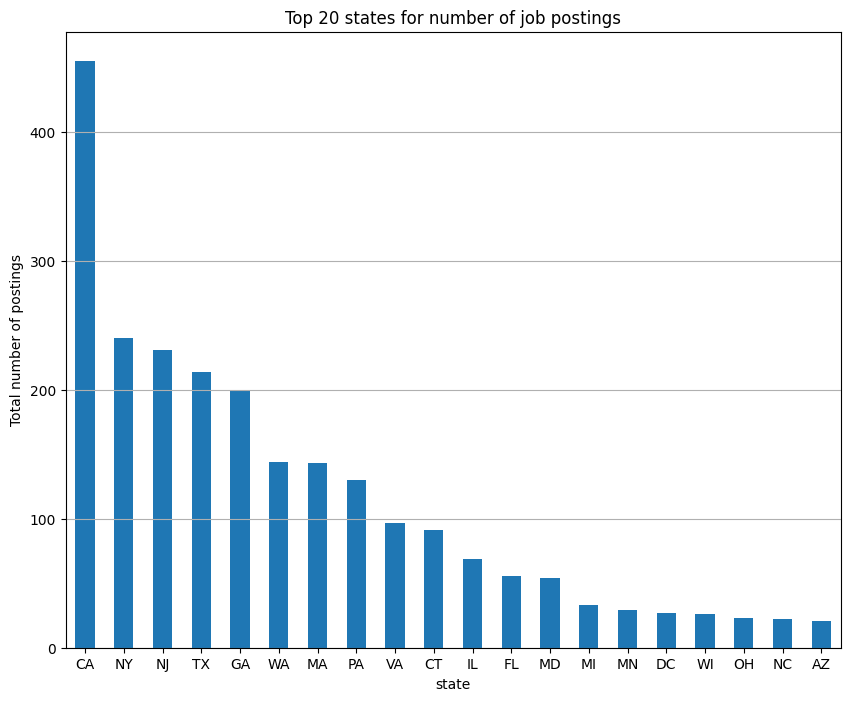

In [31]:
# Get only the state abbreviations instead of the whole address
# Retreiving only the abbreviation directly after the ','
ds['state'] = ds['joblocation_address'].str.split(',').str[1].str.strip()

# Count the jobs per state and only get the top 20
state_count = ds['state'].value_counts()
top = state_count.head(20)

# Create and plot the bar graph
plt.figure(figsize=(10,8))
top.plot(kind="bar")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.ylabel('Total number of postings')
plt.title('Top 20 states for number of job postings')
plt.show()

Graph 2: Pie chart for the number of job titles (only show top 10)

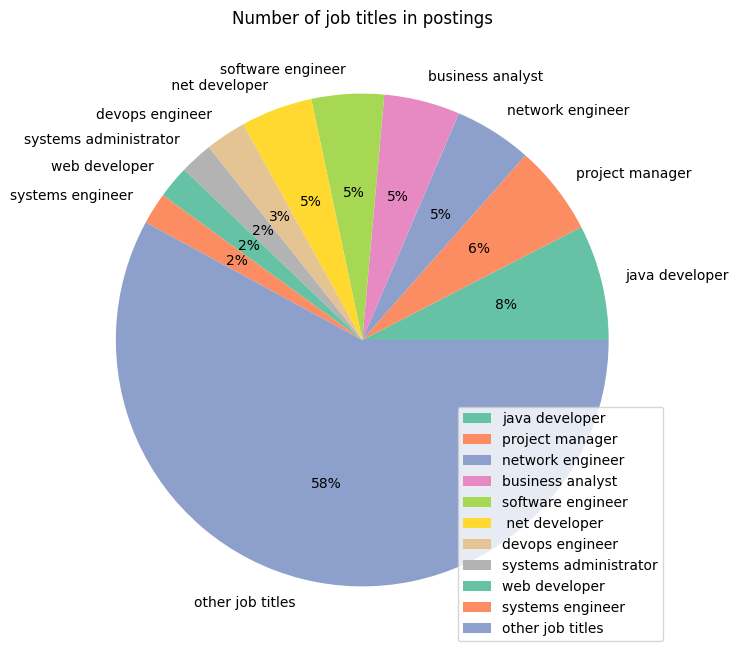

In [36]:
# Using a regular expression function to get rid of numbers and spaces in the titles
#ds['norm_title'] = ds['jobtitle'].str.replace(r'\s*\d+$', '', regex=True)

def clean(text):
  text = text.lower()
  text = re.sub(r'\s*\d+$', ' ', text)
  return text

ds['norm_title'] = ds['jobtitle'].apply(clean)

# Count the top 10 job titles
num_jobs = ds['norm_title'].value_counts()

# Get only the top 10 and then group the rest in bottom
top = num_jobs.head(10)
bottom = num_jobs[10:].sum()
jobPie = pd.concat([top, pd.Series({'other job titles': bottom})])

#Plot the pie chart
plt.figure(figsize=(8,8))
plt.pie(jobPie, labels=jobPie.index, autopct='%1.f%%', colors=sns.color_palette('Set2'))
plt.title('Number of job titles in postings')
plt.legend()
plt.show()

Graph 3: A bar graph to show the top 20 skills that are mented in job postings

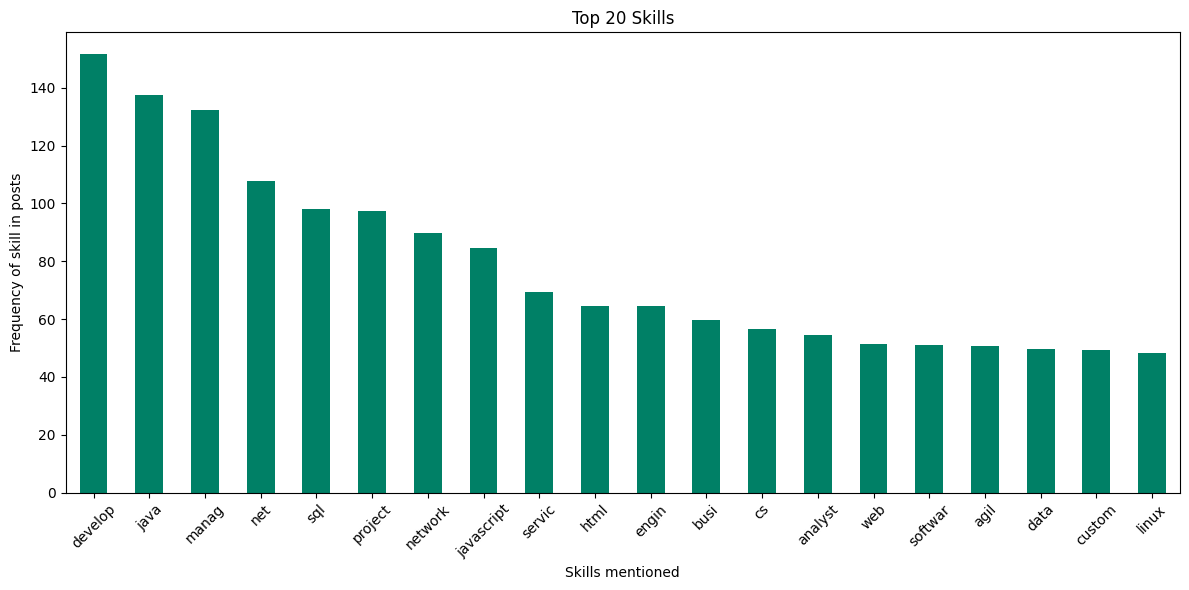

In [33]:
# Vectorizing the skills column using the same kind of vectorizer already used in model
vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
vect_skills = vectorizer.fit_transform(ds['skills'])

# Turns the vectorized skills into an array in a new data frame to use with pandas
dataframe_skills = pd.DataFrame(vect_skills.toarray(), columns=vectorizer.get_feature_names_out())
# Sums the skills and puts them in order from most to least then get only the top 20
skill_counts = dataframe_skills.sum().sort_values(ascending=False)
top = skill_counts.head(20)

# Create the bar graph and show only the top 20 skills
plt.figure(figsize=(12,6))
top.plot(kind="bar", colormap='summer')
plt.title('Top 20 Skills')
plt.xticks(rotation=45)
plt.ylabel('Frequency of skill in posts')
plt.xlabel('Skills mentioned')
plt.tight_layout()
plt.show()

A user interactive tool that allows users to input a skill and get the top relevant job listings

In [34]:
# All inside a try and except for error handling
try:
  Uinput = input("Enter your skills separated by a comma or type exit:\n")

  #End the search function is user inputs the word 'exit'
  if Uinput.lower() in ['exit']:
    print('THank you!')
  # Otherwise search for skills using the user inputs
  else:
    inputText = [Uinput]
    # User input to predict probabilities for relevant job titles
    predicted = model.predict_proba(inputText)[0]
    # Only retreive the top five titles
    chosenTop = predicted.argsort()[::-1][:5]

    top_five = []
    print('Here are top 5 job titles based on inputed skill(s): ')
    for i, userChoice in enumerate(chosenTop, 1):
      # Get the actual job titles instead of just the encoded label
      title = encode_label.inverse_transform([userChoice])[0]
      top_five.append(title)
      # Display the relevant results
      print(f"{i}.{title}")

except:
  print('An Error has occured!')

Enter your skills separated by a comma or type exit:
java
Here are top 5 job titles based on inputed skill(s): 
1.java developer
2.sr  java developer
3.senior java developer
4.core java developer
5.full stack developer
